# EDA: Bayer Leverkusen 2023/24 Season

**Author:** Cris

This notebook presents an exploratory data analysis (EDA) of Bayer Leverkusen's
on-ball actions during the 2023/24 Bundesliga season, using StatsBomb open-data
with 360 freeze-frame information.



In [23]:
# Basic
import sys
import os
import json
from pathlib import Path

# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar
from tqdm import tqdm

# Project imports
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
CODE_DIR = os.path.join(PROJECT_ROOT, "code")

if CODE_DIR not in sys.path:
    sys.path.insert(0, CODE_DIR)

# Absolute path to StatsBomb open-data directory
BASE_DIR = str(Path(PROJECT_ROOT) / "data" / "open-data" / "data")
print("Using BASE_DIR:", BASE_DIR)

from load_data import (
    load_team_matches,
    find_matches_with_360,
    load_full_match
)

sns.set_style("whitegrid")


Using BASE_DIR: C:\Users\Owner\PycharmProjects\Player-decision-simulation\data\open-data\data


## 1. Data Description and Scope

This section describes the scope of the dataset used in this exploratory data analysis.
We focus on all Bundesliga matches played by Bayer Leverkusen during the 2023/24 season,
using the StatsBomb open-data repository.


In [24]:
competition_id = 9
season_id = 281
team_name = "Leverkusen"

matches = load_team_matches(
    team_name=team_name,
    competition_id=competition_id,
    season_id=season_id,
    base_dir=BASE_DIR
)

print(f"Total matches found: {len(matches)}")
pd.DataFrame(matches).head()


Total matches found: 34


,match_id,match_date,home_team,away_team,home_score,away_score,is_home,competition_id,season_id,competition_name,season_name
0,3895302,2024-04-14,Bayer Leverkusen,Werder Bremen,5,0,True,9,281,1. Bundesliga,2023/2024
1,3895292,2024-04-06,Union Berlin,Bayer Leverkusen,0,1,False,9,281,1. Bundesliga,2023/2024
2,3895333,2024-05-05,Eintracht Frankfurt,Bayer Leverkusen,1,5,False,9,281,1. Bundesliga,2023/2024
3,3895340,2024-05-12,Bochum,Bayer Leverkusen,0,5,False,9,281,1. Bundesliga,2023/2024
4,3895348,2024-05-18,Bayer Leverkusen,Augsburg,2,1,True,9,281,1. Bundesliga,2023/2024


## 2. Availability of 360 Freeze-Frame Data


In [25]:
# Identify matches with available 360 data
matches_with_360 = find_matches_with_360(
    matches,
    base_dir=BASE_DIR
)

print(f"Matches with 360 data: {len(matches_with_360)} / {len(matches)}")


Matches with 360 data: 34 / 34


Out of the 34 Bundesliga matches played by Bayer Leverkusen in the 2023/24 season,
all matches include available 360 freeze-frame data. This allows the analysis to
incorporate spatial context for every on-ball action.


## 3. Event-Level Overview

Before focusing on passing decisions, we first provide a high-level overview of
the distribution of on-ball events recorded for Bayer Leverkusen. This helps
establish the relative importance of passing actions in the dataset.


In [26]:
# Load a single sample match to inspect event structure
sample_match_id = matches_with_360[0]

events_df, expanded_df, lineup_lookup = load_full_match(
    match_id=str(sample_match_id),
    base_dir=BASE_DIR
)

print("Event dataframe shape:", events_df.shape)
events_df["type"].value_counts().head(10)


Event dataframe shape: (4223, 13)


type
Pass             1172
Ball Receipt*    1155
Carry            1022
Pressure          432
Ball Recovery      94
Duel               52
Block              36
Goal Keeper        34
Shot               27
Dribble            26
Name: count, dtype: int64

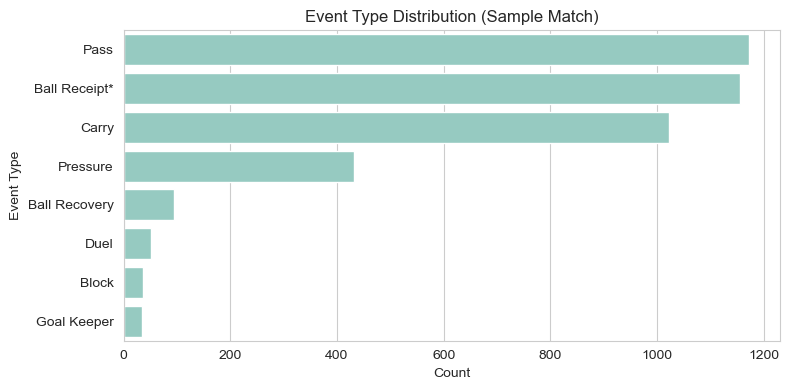

In [27]:
# Plot event type distribution
event_counts = events_df["type"].value_counts().head(8)

plt.figure(figsize=(8, 4))
sns.barplot(
    x=event_counts.values,
    y=event_counts.index,
    orient="h"
)
plt.title("Event Type Distribution (Sample Match)")
plt.xlabel("Count")
plt.ylabel("Event Type")
plt.tight_layout()
plt.show()


Passing actions account for the largest share of on-ball events in the dataset,
highlighting their central role in Bayer Leverkusen’s offensive decision-making.
This motivates a more detailed analysis of passing behavior in the following section.


## 4. Aggregate Passing Events Across the Season


We now aggregate passing events across all Bayer Leverkusen matches in the 2023/24 season to study team-level passing behavior under consistent spatial and contextual conditions.

In [28]:
# Aggregate passing events across all matches
all_passes = []

for match_id in matches_with_360:
    events_df, expanded_df, _ = load_full_match(
        match_id=str(match_id),
        base_dir=BASE_DIR
    )

    # Leverkusen pass events only
    team_passes = events_df[
        (events_df["team"] == "Bayer Leverkusen") &
        (events_df["type"] == "Pass") &
        (events_df["location"].notna()) &
        (events_df["end_location"].notna())
    ].copy()

    team_passes["match_id"] = match_id
    all_passes.append(team_passes)

passes_df = pd.concat(all_passes, ignore_index=True)

print("Total pass events:", len(passes_df))
passes_df.head()


Total pass events: 24244


,event_id,match_id,team,player,type,minute,second,location,freeze_frame,visible_area,end_location,player_id,position
0,b8ea5d17-518b-4f87-86cf-557d57345a23,3895302,Bayer Leverkusen,Nathan Tella,Pass,0,19,"[33.3, 43.2]","[{'teammate': True, 'actor': True, 'keeper': F...","[36.90379208848147, 66.31319699705554, 0.0, 3....","[8.5, 33.8]",41411.0,Right Wing Back
1,147de3eb-2cae-479d-be6f-e0e1e2dc30de,3895302,Bayer Leverkusen,Lukáš Hrádecký,Pass,0,23,"[8.5, 33.8]","[{'teammate': True, 'actor': True, 'keeper': T...","[28.92326728089324, 73.7179002788761, 0.0, 38....","[15.1, 21.5]",8667.0,Goalkeeper
2,1d43d9bb-9f3e-4ee1-85c8-1773543caa18,3895302,Bayer Leverkusen,Edmond Fayçal Tapsoba,Pass,0,27,"[22.3, 19.5]",[],[],"[38.1, 19.5]",30606.0,Left Center Back
3,ba58c1f0-2eb3-4a70-86e3-50cea43cb3b8,3895302,Bayer Leverkusen,Robert Andrich,Pass,0,28,"[38.1, 19.5]","[{'teammate': True, 'actor': False, 'keeper': ...","[34.66876364795742, 67.61360225685317, 0.0, 3....","[29.9, 19.5]",9195.0,Left Defensive Midfield
4,029cd118-dc2a-4e3d-aa44-39288ac3e700,3895302,Bayer Leverkusen,Edmond Fayçal Tapsoba,Pass,0,37,"[48.1, 28.6]","[{'teammate': True, 'actor': False, 'keeper': ...","[46.24418120389823, 64.58916674572141, 21.5841...","[48.6, 49.7]",30606.0,Left Center Back


In [29]:
passes_df[["player", "match_id"]].nunique()


player      24
match_id    34
dtype: int64

Across the 2023/24 Bundesliga season, Bayer Leverkusen recorded a total of 24,244 pass events
across 34 matches. These passes were made by 24 unique players, forming the basis for the
subsequent spatial and contextual analysis of passing decisions.


## 5. Spatial Distribution of Pass Origins


We first examine where passes are initiated on the pitch to understand Bayer Leverkusen’s overall spatial passing structure.

In [30]:
# Extract pass start locations
passes_df["x"] = passes_df["location"].apply(lambda l: l[0])
passes_df["y"] = passes_df["location"].apply(lambda l: l[1])

passes_df[["x", "y"]].describe()


,x,y
count,24244.000000,24244.000000
mean,63.361689,39.734491
std,26.260205,22.763147
min,0.700000,0.100000
25%,46.000000,20.400000
50%,64.200000,39.700000
75%,82.600000,59.000000
max,120.000000,80.000000


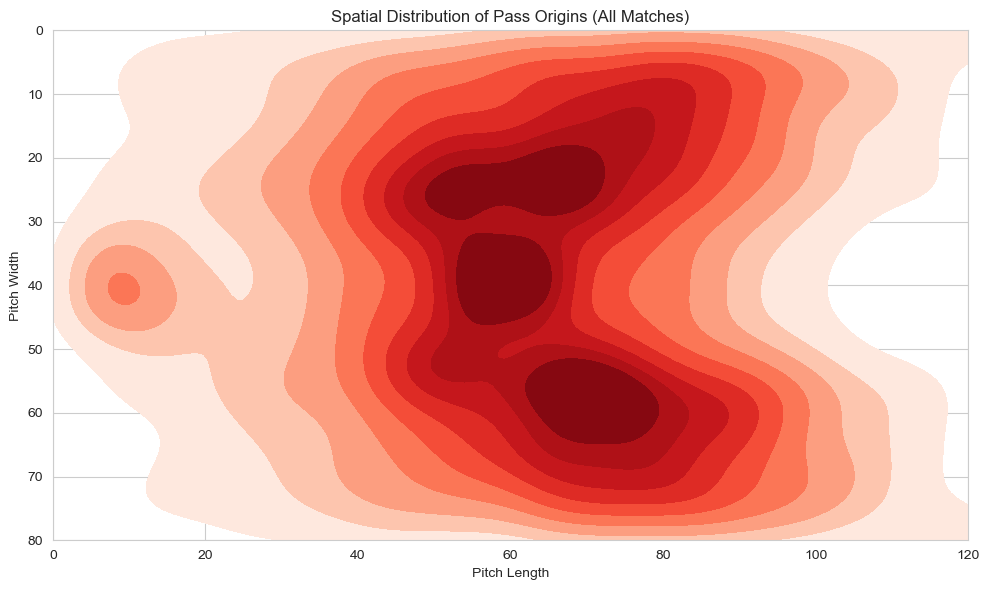

In [31]:
plt.figure(figsize=(10, 6))

sns.kdeplot(
    x=passes_df["x"],
    y=passes_df["y"],
    fill=True,
    cmap="Reds",
    thresh=0.05
)

plt.title("Spatial Distribution of Pass Origins (All Matches)")
plt.xlabel("Pitch Length")
plt.ylabel("Pitch Width")
plt.xlim(0, 120)
plt.ylim(0, 80)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


The spatial density map shows where Bayer Leverkusen most frequently initiate passes across the 2023/24 Bundesliga season.

Several clear patterns emerge. First, pass origins are heavily concentrated in the central corridor of the pitch, particularly in the middle third. This indicates a strong preference for circulating possession through central midfield areas rather than relying primarily on wide build-up.

Second, there is noticeable pass activity extending into the attacking half, especially around the half-spaces, suggesting Leverkusen’s tendency to progress the ball through controlled passing sequences rather than long direct play. In contrast, relatively fewer passes originate deep in the defensive corners, reflecting a structured build-up that avoids unnecessary circulation close to the defensive goal line.

Overall, this spatial distribution highlights a possession-oriented passing structure, where decisions are frequently made in zones with high player density and multiple passing options. This motivates subsequent analysis of how spatial context—such as player positioning and pressure—may influence individual passing decisions.

## 6. Passing Behavior Under Defensive Pressure


In this section, we examine how Bayer Leverkusen’s passing behavior varies under different spatial and pressure-related contexts. Using StatsBomb 360 freeze-frame data, we quantify defensive proximity at the moment of passing and explore how passing distance and direction change under pressure.

### 6.1 Defensive Proximity at Pass Initiation


In this subsection, we quantify defensive proximity at the moment of pass initiation using 360 freeze-frame data. Defensive pressure is operationalized as the distance to the closest opposing player at the time of the pass. This measure serves as a contextual indicator for subsequent analyses.

In [38]:
def min_defender_distance(row):
    """
    Compute distance to closest opponent at pass moment.
    """
    ff = row["freeze_frame"]
    if not isinstance(ff, list) or len(ff) == 0:
        return np.nan

    passer_x, passer_y = row["location"]
    dists = []

    for p in ff:
        if not p.get("teammate", True):  # opponent
            ox, oy = p["location"]
            dists.append(np.hypot(passer_x - ox, passer_y - oy))

    return min(dists) if dists else np.nan


passes_df["defender_dist"] = passes_df.apply(min_defender_distance, axis=1)
passes_df["defender_dist"].describe()


count    20710.000000
mean         4.854176
std          4.200738
min          0.130172
25%          2.401427
50%          3.782888
75%          5.925073
max         52.138896
Name: defender_dist, dtype: float64

### 6.2 Distribution of Defensive Pressure on Passes

We first examine the distribution of defensive proximity across all passing events to understand how frequently passes are executed under close defensive pressure.

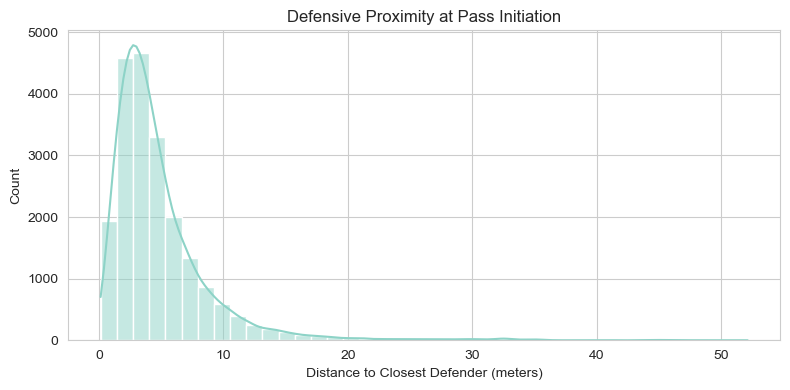

In [33]:
plt.figure(figsize=(8, 4))
sns.histplot(
    passes_df["defender_dist"].dropna(),
    bins=40,
    kde=True
)
plt.xlabel("Distance to Closest Defender (meters)")
plt.title("Defensive Proximity at Pass Initiation")
plt.tight_layout()
plt.show()


### 6.3 Pass Length Under Different Pressure Levels

We next compare pass lengths between pressured and non-pressured situations to explore whether passing distance varies systematically under defensive pressure.

In [34]:
passes_df["pass_length"] = passes_df.apply(
    lambda r: np.hypot(
        r["end_location"][0] - r["location"][0],
        r["end_location"][1] - r["location"][1]
    ),
    axis=1
)
PRESSURE_THRESH = 3.5  # meters

passes_df["pressure"] = np.where(
    passes_df["defender_dist"] <= PRESSURE_THRESH,
    "Under Pressure",
    "Not Under Pressure"
)


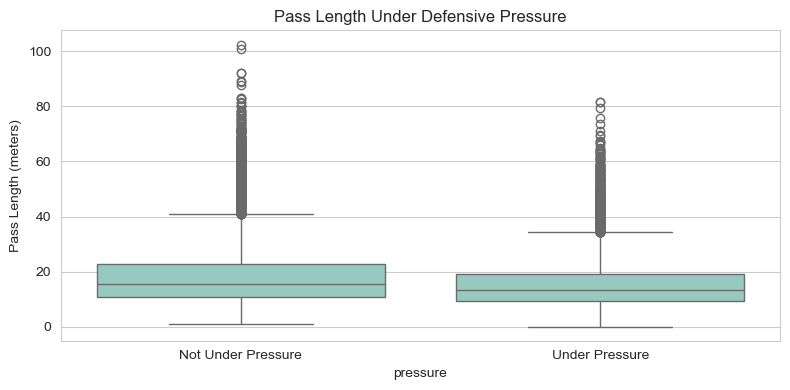

In [35]:
plt.figure(figsize=(8, 4))
sns.boxplot(
    data=passes_df,
    x="pressure",
    y="pass_length"
)
plt.ylabel("Pass Length (meters)")
plt.title("Pass Length Under Defensive Pressure")
plt.tight_layout()
plt.show()


### 6.4 Forward Progression Under Pressure

To further characterize passing decisions under pressure, we examine whether the likelihood of forward passes differs between pressured and non-pressured contexts, where a forward pass is defined as one that increases the ball’s x-coordinate.

In [36]:
passes_df["forward"] = passes_df["end_location"].apply(
    lambda x: x[0]
) > passes_df["location"].apply(
    lambda x: x[0]
)

forward_rate = (
    passes_df
    .groupby("pressure")["forward"]
    .mean()
    .reset_index()
)

forward_rate


,pressure,forward
0,Not Under Pressure,0.627702
1,Under Pressure,0.513797


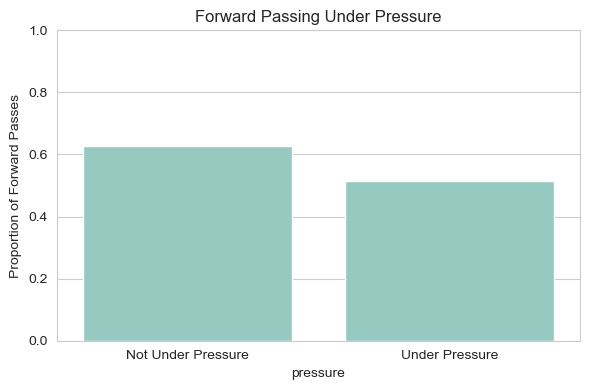

In [37]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=forward_rate,
    x="pressure",
    y="forward"
)
plt.ylabel("Proportion of Forward Passes")
plt.title("Forward Passing Under Pressure")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


### 6.5 Spatial Distribution of Passes Under Defensive Pressure

Finally, we examine how defensive pressure varies spatially across the pitch by aggregating defender proximity by pass origin location. This visualization highlights how pressure context is distributed across different zones of the field.

In [47]:
# Bin pitch into grid cells
passes_df["x_bin"] = pd.cut(passes_df["x"], bins=np.linspace(0, 120, 13))
passes_df["y_bin"] = pd.cut(passes_df["y"], bins=np.linspace(0, 80, 9))

In [48]:
pressure_map = (
    passes_df
    .groupby(["x_bin", "y_bin"])["defender_dist"]
    .mean()
    .reset_index()
)


C:\Users\Owner\AppData\Local\Temp\ipykernel_66644\3382633358.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["x_bin", "y_bin"])["defender_dist"]


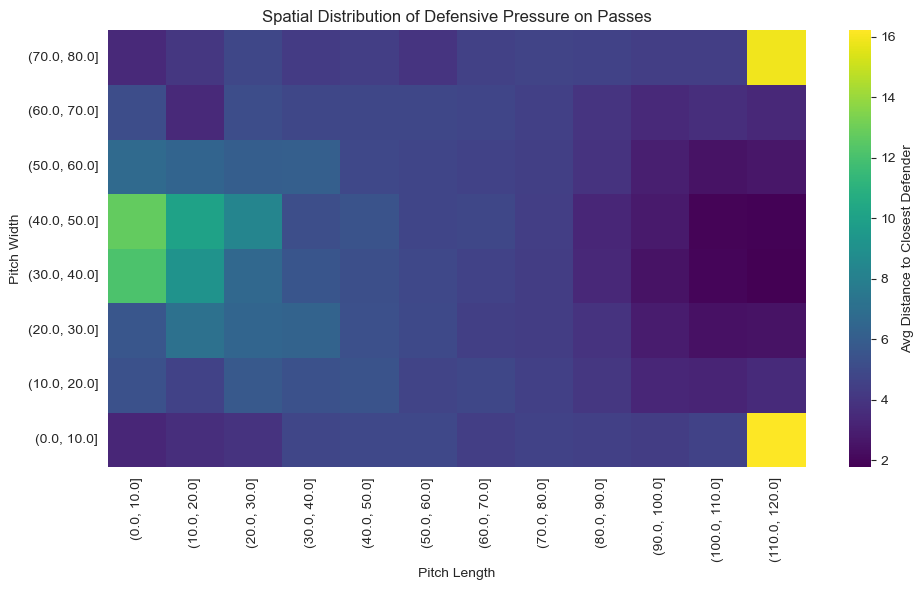

In [46]:
pivot = pressure_map.pivot(
    index="y_bin",
    columns="x_bin",
    values="defender_dist"
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot,
    cmap="viridis",
    cbar_kws={"label": "Avg Distance to Closest Defender"}
)

plt.title("Spatial Distribution of Defensive Pressure on Passes")
plt.xlabel("Pitch Length")
plt.ylabel("Pitch Width")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


This heatmap reveals clear spatial variation in defensive pressure at the moment of passing. Passes initiated in central midfield zones tend to occur under closer defensive proximity, while wider and deeper areas exhibit larger average distances to the nearest defender. This highlights how passing context is shaped not only by individual situations but also by spatial positioning on the pitch.

#### Section 6 Summary
Overall, this section demonstrates that Bayer Leverkusen’s passing behavior is strongly conditioned on defensive pressure and spatial context. Passes under pressure tend to be shorter, less forward-oriented, and concentrated in specific areas of the pitch. These findings emphasize the importance of incorporating defender-aware and spatial features when modeling on-ball decision-making, motivating more structured analyses in subsequent sections.

## 7. Summary of Key Findings and Analytical Implications

This exploratory data analysis examined Bayer Leverkusen’s passing behavior during the 2023/24 Bundesliga season with a particular focus on spatial and pressure-related context using StatsBomb 360 data. Several consistent patterns emerge across the preceding sections.

First, passing constitutes the dominant on-ball action in Leverkusen’s matches, motivating a focused analysis on passing decisions at the team level (Section 4). Spatial analysis of pass origins shows a structured buildup pattern, with a high concentration of passes initiated in central and half-space regions of the pitch (Section 5).

Incorporating freeze-frame information enables a contextual analysis of defensive pressure at the moment of passing. The distribution of defender proximity indicates that a substantial fraction of passes are executed with an opposing player in close proximity (Section 6.1–6.2). Conditional analyses further reveal systematic behavioral differences under pressure: passes tend to be shorter and are less likely to progress the ball forward when defensive pressure is present (Sections 6.3–6.4).

Finally, spatial aggregation of defensive proximity highlights that pressure is not uniformly distributed across the pitch, with distinct zones exhibiting consistently higher or lower levels of defensive pressure (Section 6.5). Together, these findings underscore the importance of incorporating spatial and contextual features—such as defender proximity—when analyzing passing behavior.

Overall, this EDA demonstrates how freeze-frame data can enrich traditional event-based analysis by providing actionable context for decision-making. These insights motivate future modeling approaches that explicitly account for defensive pressure and spatial structure in passing decisions.